# Introduction to Convolutional Neural Networks (CNNs) in PyTorch

(Adapted from notebooks by Kevin Liang and Matthew Kenney)

### Representing images digitally

While convolutional neural networks (CNNs) see a wide variety of uses, they were originally designed for images, and CNNs are still most commonly used for vision-related tasks.
For today, we'll primarily be focusing on CNNs for images.
Before we dive into convolutions and neural networks, it's worth prefacing with how images are represented by a computer, as this understanding will inform some of our design choices.

Previously, we saw an example of a digitized MNIST handwritten digit.
Specifically, we represent it as an $H \times W$ table, with the value of each element storing the intensity of the corresponding pixel.

<img src="https://github.com/kevinjliang/PyTorchTutorials/blob/master/Figures/mnist_digital.PNG?raw=1" alt="mnist_digital" style="width: 600px;"/>

With a 2D representation as above, we for the most part can only efficiently represent grayscale images.
What if we want color?
There are many schemes for storing color, but one of the most common ones is the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model).
In such a system, we store 3 tables of pixel intensities (each called a *channel*), one each for the colors red, green, and blue (hence RGB), resulting in an $H \times W \times 3$ array. Note that PyTorch uses variables called **tensors** under the hood, and this is just a different name for an n-dimensional array.
Pixel values for a particular channel indicate how much of the corresponding color the image has at a particular location.

Let's load an image and see this:

In [ ]:
!wget https://raw.githubusercontent.com/kevinjliang/PyTorchTutorials/master/Figures/chapel.jpg

--2020-08-19 17:19:56--  https://raw.githubusercontent.com/kevinjliang/PyTorchTutorials/master/Figures/chapel.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 302781 (296K) [image/jpeg]
Saving to: ‘chapel.jpg’

chapel.jpg          100%[===================>] 295.68K  --.-KB/s    in 0.008s  

2020-08-19 17:19:57 (37.4 MB/s) - ‘chapel.jpg’ saved [302781/302781]



Shape of the image tensor: (620, 1175, 3)


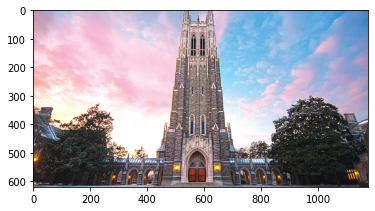

In [ ]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Read image
im = imageio.imread("/content/chapel.jpg")
print("Shape of the image tensor: {}".format(im.shape))
plt.imshow(im)

We can see that the image we loaded has height and width of $620 \times 1175$, with 3 channels corresponding to RGB.

We can easily slice out and view individual color channels:

(620, 1175)


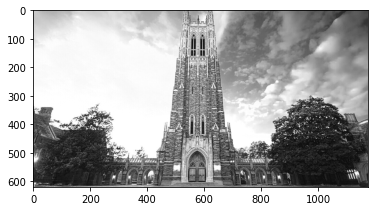

In [ ]:
# Red channel
im_red = im[:,:,0]
print(im_red.shape)
plt.imshow(im_red, cmap='gray')

(620, 1175)


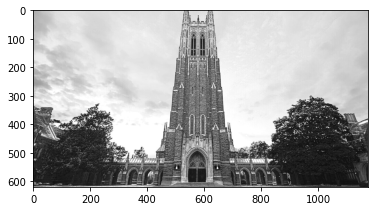

In [ ]:
# Blue channel
im_blue = im[:,:,2]
print(im_blue.shape)
plt.imshow(im_blue, cmap='gray')

The pixel values inside these arrays can also be inspected and processed in a myriad of ways.

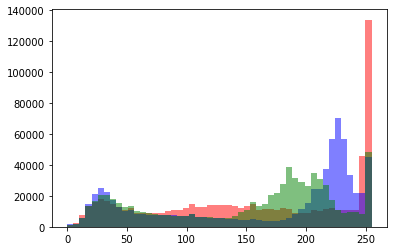

In [ ]:
plt.figure()
plt.hist(im[:,:,0].ravel(),50,color='r',alpha=0.5)
plt.hist(im[:,:,2].ravel(),50,color='b',alpha=0.5)
plt.hist(im[:,:,1].ravel(),50,color='g',alpha=0.5)
plt.show()

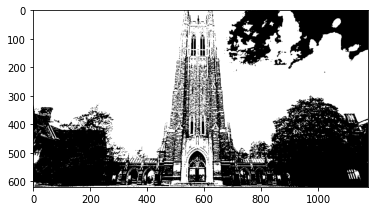

In [ ]:
plt.figure()
plt.imshow(im[:,:,0]>125,cmap='gray')

While we have so far considered only 3 channel RGB images, there are many settings in which we may consider a different number of channels.
For example, [hyperspectral imaging](https://en.wikipedia.org/wiki/Hyperspectral_imaging) uses a wide range of the electromagnetic spectrum to characterize a scene.
Such modalities may have hundreds of channels or more.
Additionally, we'll soon see that certain intermediate representations in a CNN can be considered images with many channels.
However, we'll focus much of today's discussion to 1 channel grayscale and 3 channel RGB images as our inputs, as is most commonly the case in computer vision.

### Loading Images For Training a CNN

To train over a large dataset, we can either (a) use academic dataset repositories available online, or (b) populate a directory of our own images. 

Here we'll start by using the readily available MNIST dataset.

In the second half of the notebook, you'll find an example of using a custom image dataset.

In [ ]:
import numpy as np
from torchvision import datasets, transforms

data_transforms = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(90),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=data_transforms, download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=data_transforms, download=True)

After loading the data, we now have dataset objects that contain and images and associated class labels that we need to train out network. 

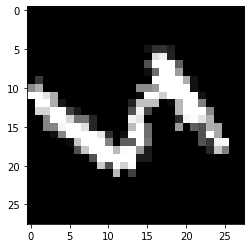

In [ ]:
plt.figure()
plt.imshow(mnist_train.__getitem__(0)[0][0],cmap='gray')

tensor(5)

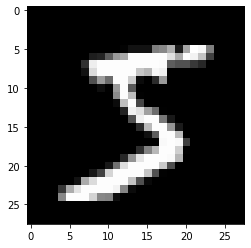

In [ ]:
plt.figure()
plt.imshow(mnist_train.data[0], cmap='gray')
mnist_train.targets[0]

In [ ]:
mnist_train.

# Building the CNN

<img src="https://raw.githubusercontent.com/duke-mlss/PlusDataScience/master/Figures/mnist_cnn_example.png" alt="mnist_cnn_ex" style="width: 500px;"/>



### Convolutions
Convolutional neural networks (CNNs) are a class of neural networks that have convolutional layers.
CNNs are particularly effective for data that have spatial structures and correlations (e.g. images).
We'll focus on CNNs applied to images in this tutorial.
Recall that a multilayer perceptron (MLP) is entirely composed of fully connected layers, which are each a matrix multiply operation (and addition of a bias) followed by a non-linearity (e.g. sigmoid, ReLU). 
A convolutional layer is similar, except the matrix multiply operation is replaced with a convolution operation (in practice a cross-correlation). 
Note that a CNN need not be entirely composed of convolutional layers; in fact, many popular CNN architectures end in fully connected layers.

### Activation Functions

At the end of a convolutional layer, each neuron in the resulting feature map passes its value through an activation function that introduces a non-linearity critical for making the network expressive. The ReLU function is the most common activation function, although there are others.

![alt text](https://www.researchgate.net/profile/Hossam_H_Sultan/publication/333411007/figure/fig7/AS:766785846525952@1559827400204/ReLU-activation-function.png)

Tensorflow provides an [online playground](https://playground.tensorflow.org) where you can go and see for your self how linear vs. non-linear activation functions influence classification performance.

### Pooling

Almost all CNN architectures incorporate pooling. This is done for a number of reasons, including:
- Dimensionality reduction: pooling operations reduces computational complexity by shrinking the number of values passed to the next layer.
For example, a 2x2 maxpool reduces the size of the feature maps by a factor of 4.
- Translational invariance: Oftentimes in computer vision, we'd prefer that shifting the input by a few pixels doesn't change the output. Pooling reduces sensitivity to exact pixel locations.
- Increasing receptive field: by summarizing a window with a single value, subsequent convolutional kernels are seeing a wider swath of the original input image. For example, a max pool on some input followed by a 3x3 convolution results in a kernel "seeing" a 6x6 region instead of 3x3.

The most common form of pooling is max pooling, which reduces values within a window to a single value, on a per-feature-map basis.
Max pooling takes the maximum value of the window as the output value.

<img src="https://github.com/kevinjliang/PyTorchTutorials/blob/master/Figures/maxpool.PNG?raw=1" alt="avg_vs_max" style="width: 400px;"/>

### Fully connected layers

Fully connected (fc) layers are used to generate predicted class outputs, so the last fc layer in the network has as many neurons as there are output classes. Fully connected means each neuron is connected to all neurons in the set of feature maps preceding it, with a weight (aka parameter) for each of these connections. fc layers use input that is vectorized (aka flattened).

<img src="https://raw.githubusercontent.com/duke-mlss/PlusDataScience/master/Figures/mnist_cnn_fc.png" alt="mnist_cnn_fc" style="height: 100px;"/>

### The Code

#### Defining the network architecture

We'll use the following CNN as our classifier for MNIST (slightly different than in the diagram): $5 \times 5$ convolution -> $2 \times 2$ max pool -> $5 \times 5$ convolution -> $2 \times 2$ max pool -> fully connected to $\mathbb R^{256}$ -> fully connected to $\mathbb R^{10}$ (prediction). 
ReLU activation functions will be used to impose non-linearities.
Remember, convolutions produce 4-D outputs, and fully connected layers expect 2-D inputs, so tensors must be reshaped when transitioning from one to the other.

In [ ]:
import torch
import torch.nn as nn

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        
        # fc layer 1
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        
        # fc layer 2
        x = self.fc2(x)
        return x        

Notice how our `nn.Module` contains several operation chained together.
The code for submodule initialization, which creates all the stateful parameters associated with each operation, is placed in the `__init__()` function, where it is run once during object instantiation.
Meanwhile, the code describing the forward pass, which is used every time the model is run, is placed in the `forward()` method.

We can use the `torchsummary` library to print out a nice list of all our layers and their shapes, given an expected input shape.

In [ ]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = MNIST_CNN() #instantiate the model
moddel = model.to(device) #send the model to the gpu if we have one

summary(model,(1,) + mnist_train.data[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 857,738
Trainable params: 857,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 3.27
Estimated T

#### Training the network

The code below accomplishes several things.

- Creates data loader objects that generate batches of data on request. Remember that after each batch is passed through the network, there is a gradient update via the optimizer.

- Defines the type of loss function we will use for optimization, and defines the type of optimizer we will use.

- Loops over all of the data `num_epochs` of times, and updates the weights (i.e. parameters) after each batch. This trains the network so that its output is matches the true labels associated with each image.

- After `num_epochs`, training stops, and the model is then tested on images that were not in the training set. The acuracy over this test set is calculated and displayed.

Note: check out [PyTorchLightning](https://github.com/PyTorchLightning/pytorch-lightning) if you're interested in simplying your training loop code.


In [ ]:
# Import some progress bar utilities to keep track of training.
from tqdm.notebook import tqdm, trange

# Send the dataset objects to the data loader, which will generate batches of data used for training.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_history = []

# Iterate through train set minibatchs
num_epochs = 3 
for epoch in trange(num_epochs):
    for images, labels in tqdm(train_loader):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = images.to(device)
        labels = labels.to(device)
        y = model(x)
        loss = criterion(y, labels)

        loss_history.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.to(device)
        y = model(x)
        labels = labels.to(device)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9907999634742737


If you are running this notebook on CPU, training this CNN might take a while.
On the other hand, if you use a GPU, this model should train in seconds.
This is why we usually prefer to use GPUs when we have them.

In our training loop, we collected the loss after every batch into a list that we can plot and examine.

Text(0.5, 0, 'batch #')

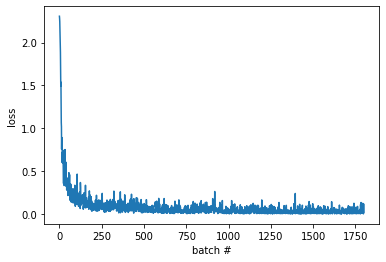

In [ ]:
plt.figure()
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('batch #')

#### Datasets and transforms

As any experienced ML practioner will say, data wrangling is often half (sometimes even 90%) of the battle when building a model.
Often, we have to write significant code to handle downloading, organizing, formatting, shuffling, pre-processing, augmenting, and batching examples. 
For popular datasets, we'd like to standardize data handling so that the comparisons we make are specific to the models themselves.

Enter [Torchvision](https://pytorch.org/docs/stable/torchvision/index.html).
Torchvision includes easy-to-use APIs for downloading and loading many popular vision datasets.
We've previously seen this in action for downloading the MNIST dataset:

In [ ]:
from torchvision import datasets

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)

Of course, there's [many more](https://pytorch.org/docs/stable/torchvision/datasets.html).
Currently, datasets for image classification (e.g. MNIST, CIFAR, ImageNet), object detection (VOC, COCO, Cityscapes), and video action recognition (UCF101, Kinetics) are included.

For formatting, pre-processing, and augmenting, [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) can come in handy.
Again, we've seen this before (see above), when we used a transform to convert the MNIST data from PIL images to PyTorch tensors.
However, transforms can be used for much more. 
Preprocessing steps like data whitening are common before feeding the data into the model.
Also, in many cases, we use data augmentations to artificially inflate our dataset and learn invariances.
Transforms are a versatile tool for all of these.

#### Leveraging popular convolutional neural networks

While you certainly can build your own custom CNNs like we did above, more often than not, it's better to use one of the popular existing architectures. 
The Torchvision documentation has a [list of supported CNNs](https://pytorch.org/docs/stable/torchvision/models.html), as well as some performance characteristics. 
There's a number of reasons for using one of these CNNs instead of designing your own.

First, for image datasets larger and more complex than MNIST (which is basically all of them), a fair amount network depth and width is often necessary.
For example, some of the popular CNNs can be over 100 layers deep, with several tricks and details beyond what we've covered in this notebook.
Coding all of this yourself has a high potential for error, especially when you're first getting started.
Instead, you can create the CNN architecture using Torchvision, using a couple lines:

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18()

Loading a working CNN architecture in a couple lines can save a significant amount of time both implementing and debugging.

The second, perhaps even more important, reason to use one of these existing architectures is the ability to use pre-trained weights.
Early on in the recent resurgence of deep learning, people discovered that the weights of a CNN trained for ImageNet classification were highly transferable. 
For example, it is common to use the weights of an ImageNet-trained CNN as a weight initialization for other vision tasks, or even to freeze the bulk of the weights and only re-train the final classification layer(s) on a new task.
This is significant, as in most settings, we rarely have enough labeled data to train a powerful CNN from scratch without overfitting.
Loading pre-trained CNN is also pretty simple, involving an additional argument to the previous cell block:

In [ ]:
model_ft = models.resnet18(pretrained=True)

### Using a pre-trained network with your own data

In [ ]:
import torch.optim as optim
import os

Our next step is to define our data transformations. We'll be working with images, so we'll do some basic data augmentation to improve the accuracy of the model that we're finetuning. We can define the transformations using the PyTorch transforms.Compose function. Within `transforms.Compose`, we can define which transformations we would like to apply to our images. Here, we'll use a `RandomResizedCrop` and RandomHorizontalFlip. `RandomResizedCrop` resizes the images to 224. `RandomHorizontalFlip` randomly flips images along the horizontal axis. Next, we'll take the images and convert them to tensors with `ToTensor`. You'll recall that its necessary to convert images to tensors for our network to read. Lastly, we'll normalize these tensors with a `Normalize` call. This call take each tensor and normalizes the numbers to the values we've defined. Here, we're using standard values based off of ImageNet (imagenet.org) images. These numbers are precalculated, and generally work well across most standard images.

In [ ]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms_test = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Now we'll download and unzip a new dataset of two different color image classes -- ants vs. bees.

In [ ]:
!gdown https://drive.google.com/uc?id=1Axnf5OODNas7x3_6hBqC_jG3dUsSXoiY

Downloading...
From: https://drive.google.com/uc?id=1Axnf5OODNas7x3_6hBqC_jG3dUsSXoiY
To: /content/ants_vs_bees.zip
47.6MB [00:00, 152MB/s] 


In [ ]:
!unzip ants_vs_bees.zip

Archive:  ants_vs_bees.zip
replace ants_vs_bees/test/bees/2717418782_bd83307d9f.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ants_vs_bees/test/bees/2717418782_bd83307d9f.jpg  
  inflating: __MACOSX/ants_vs_bees/test/bees/._2717418782_bd83307d9f.jpg  
  inflating: ants_vs_bees/test/bees/2173503984_9c6aaaa7e2.jpg  
  inflating: __MACOSX/ants_vs_bees/test/bees/._2173503984_9c6aaaa7e2.jpg  
  inflating: ants_vs_bees/test/bees/54736755_c057723f64.jpg  
  inflating: __MACOSX/ants_vs_bees/test/bees/._54736755_c057723f64.jpg  
  inflating: ants_vs_bees/test/bees/2103637821_8d26ee6b90.jpg  
  inflating: __MACOSX/ants_vs_bees/test/bees/._2103637821_8d26ee6b90.jpg  
  inflating: ants_vs_bees/test/bees/603711658_4c8cd2201e.jpg  
  inflating: __MACOSX/ants_vs_bees/test/bees/._603711658_4c8cd2201e.jpg  
  inflating: ants_vs_bees/test/bees/238161922_55fa9a76ae.jpg  
  inflating: __MACOSX/ants_vs_bees/test/bees/._238161922_55fa9a76ae.jpg  
  inflating: ants_vs_bees/test/bees/2457841282_78

Check out how the image folder is organized. If you have your own images you want to train a classifier on, you'll need to follow this structure of having a train folder and a test folder, with each having subfolders for each class. The images for each class are then deposited in these class subfolders.

In [ ]:
ls ./ants_vs_bees/train/bees/

1092977343_cb42b38d62.jpg  2486729079_62df0920be.jpg  3074585407_9854eb3153.jpg
1093831624_fb5fbe2308.jpg  2486746709_c43cec0e42.jpg  3079610310_ac2d0ae7bc.jpg
1097045929_1753d1c765.jpg  2493379287_4100e1dacc.jpg  3090975720_71f12e6de4.jpg
1232245714_f862fbe385.jpg  2495722465_879acf9d85.jpg  3100226504_c0d4f1e3f1.jpg
129236073_0985e91c7d.jpg   2528444139_fa728b0f5b.jpg  342758693_c56b89b6b6.jpg
1295655112_7813f37d21.jpg  2538361678_9da84b77e3.jpg  354167719_22dca13752.jpg
132511197_0b86ad0fff.jpg   2551813042_8a070aeb2b.jpg  359928878_b3b418c728.jpg
132826773_dbbcb117b9.jpg   2580598377_a4caecdb54.jpg  365759866_b15700c59b.jpg
150013791_969d9a968b.jpg   2601176055_8464e6aa71.jpg  36900412_92b81831ad.jpg
1508176360_2972117c9d.jpg  2610833167_79bf0bcae5.jpg  39672681_1302d204d1.jpg
154600396_53e1252e52.jpg   2610838525_fe8e3cae47.jpg  39747887_42df2855ee.jpg
16838648_415acd9e3f.jpg    2617161745_fa3ebe85b4.jpg  421515404_e87569fd8b.jpg
1691282715_0addfdf5e8.jpg  2625499656_e3415e374d.jp

In [ ]:
ls ./ants_vs_bees/train/

ants/  bees/


In [ ]:
ls ./ants_vs_bees/train/ants/

 0013035.jpg                 408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    5

In [ ]:
# Let's display a sample image for each class
ant_ims = os.listdir('./ants_vs_bees/train/ants/')
bee_ims = os.listdir('./ants_vs_bees/train/bees/')

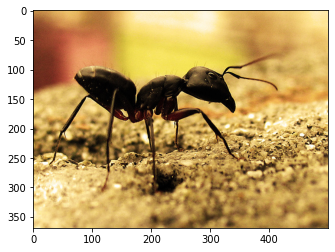

In [ ]:
plt.figure()
plt.imshow(imageio.imread('./ants_vs_bees/train/ants/' + ant_ims[0]))

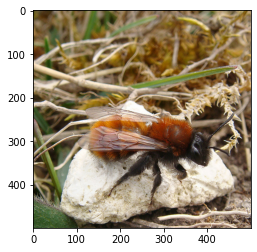

In [ ]:
plt.figure()
plt.imshow(imageio.imread('./ants_vs_bees/train/bees/' + bee_ims[0]))

Next, we'll pull in these data and define the train and test datasets. We'll use the datasets.ImageFolder PyTorch function to pull in the images for both training and testing. We'll also apply the data transformations defined above to our images. Again, these transormations crop, resize, flip, normalize, and convert the images to tensors, per our definitions in the cell above.

In [ ]:
train_data = datasets.ImageFolder('./ants_vs_bees/train', transform=data_transforms)
test_data = datasets.ImageFolder('./ants_vs_bees/test', transform=data_transforms_test)

The next step is to define our dataloaders with the `utils.data.DataLoader` function. This takes our training and test set defined above, and creates batches of images. With this function, our data is now prepared to be fed into our network.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

We loaded in `model_ft` as a pre-trained ResNet18 network. Note that the last layer is a fully connected layer with 1000 outputs, for the 1000 classes in the ImageNet database that it was pretrained on. We need to change that final layer to have just 1 output, to do binary ant/bee classification.

In [ ]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs = model_ft.fc.in_features # Need to know the number of features 
# coming out of the penultimate layer and into the fully connected one.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
im_shape = train_loader.__iter__().next()[0].shape
summary(model_ft,im_shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

No we define our loss function and optimizer, and then train and test on the data.

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in trange(num_epochs):
        for images, labels in tqdm(train_loader):

            inputs = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Do the forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate gradients and step
            loss.backward()
            optimizer.step()

In [ ]:
def test_model():
    ## Testing
    correct = 0
    total = len(test_data)
    model_ft.eval() # set the model into evaluation mode, which changes the 
    # behavior of the batch norm layer so that it is not sensitive to batch size
    with torch.no_grad():
        # Iterate through test set minibatchs 
        for images, labels in tqdm(test_loader):
            # Forward pass
            inputs = images.to(device)
            labels = labels.to(device)
            y = model_ft(inputs)
            
            predictions = torch.argmax(y, dim=1)
            correct += torch.sum((predictions == labels).float())
    print()
    print('Test accuracy: {}'.format(correct/total))

In [ ]:
train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

In [ ]:
test_model()



Test accuracy: 0.9738562107086182
